CNN autoencoder
## convLSTM autoencoder?

$\textit{done}$ make time steps overlapping: seems a bit better!

$\textit{done}$ try id as binary instead of dec: much better!
double check that the reshaped matrices have data at correct places

3d (40 time steps) cnn better than cnn_lstm, try lstm after?
3d cnn performs better on 40 ts (40 is slightly different!) than 20 , test with binary cross entropy instead of mse, test 60 timesteps
more time steps pull normal and attack apart more, but I think this is because there are many consequtive attack packets in the data and in many cases longer time windows will simply contain more attack packets. 
## tune 3d cnn
## compare with straight forward lstm. keep getting NaN, exploding/vanishing gradients?
## just add ids as another feature normal lstm?
## convLSTM 
## bidirectional LSTM
## randomly pick boxes from entire dataset
batch normalization 
## batchnorm for convlstm
## add dropout? seems to improve cannolo test slightly
## add dense layer as output? seems to improve cannolo test slightly

## Prepare data

In [1]:
from matplotlib import pyplot 
import keras
import pickle
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed 
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import UpSampling3D
from keras.layers import MaxPool3D
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2DTranspose
from keras.layers import Conv3DTranspose
from keras.layers import BatchNormalization
from keras.layers import AveragePooling3D
from keras.layers import Activation
from keras.layers import ConvLSTM2D

from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from numpy import array

In [2]:
filename = 'dataframe_training_new.zip'
df = pd.read_pickle(filename, compression='zip')
ID_vector = df['ID']

dataValues = df.drop(["Total Time", "Attack", "ID", "Packet Deltatime", "Attack Window Number", "Normal Window Number"], axis = 1).copy()

dataValues = dataValues.to_numpy()

In [14]:
dataValues

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

In [ ]:
read_file = pd.read_pickle('normal_and_attack_data')
read_file.to_csv (r'normal_and_attack_data.csv', index=None)

In [15]:
filename = 'dataframe_validation_normal_new.zip'
df = pd.read_pickle(filename, compression='zip')
df.to_csv (r'dataframe_validation_normal_new.csv', index=None)

In [22]:
training_filename = 'dataframe_training_new.csv'
training_df = pd.read_csv(training_filename, sep=',')
allRowsTraining = training_df.shape[0]

training_IDs = training_df['ID']
#training_dataValues = training_df.drop(["Timestamp", "ID", "DLC", "Attack Window Number", "Normal Window Number", "Data1", "Data2", "Data3", "Data4", "Data5", "Data6", "Data7", "Data8","Total Time", "Attack", "Packet Deltatime"], axis = 1).copy()
training_dataValues = training_df.drop([ "ID", "Packet Deltatime", "Attack","Attack Window Number", "Normal Window Number","Total Time"], axis = 1).copy()

training_dataValues = training_dataValues.to_numpy() 

n_steps = int(allRowsTraining/10000) # about 10k in each step #127 before
print(n_steps)

49


In [19]:
dataValues = df.drop([ "ID", "Packet Deltatime", "Attack","Attack Window Number", "Normal Window Number","Total Time"], axis = 1).copy()


In [21]:
dataValues

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin54,bin55,bin56,bin57,bin58,bin59,bin60,bin61,bin62,bin63
494760,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
494761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494762,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
494763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494764,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
840861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
840862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0
840863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# own data
nRows = 5000
n_timesteps = 40

filename = 'normal_and_attack_data.csv'
df = pd.read_csv(filename, nrows = nRows, sep=',')

#bin column names
bin_data_column_names = []
for j in range(64):
    bin_data_column_names.append('bin' + str(j))
    
# Få binärvärderna av de första 5 datapunkterna i en dataframe
temporary_df = df[bin_data_column_names]

# The values of these binary arrays
temporary_df_values = temporary_df.values

data = np.array(temporary_df_values)
data_with_attack = data.copy()
data = data[df['Attack'] == 'No']

IDs = df['ID']
AttackIDs = IDs.copy()
IDs = IDs[df['Attack'] == 'No']

from prepare_data_cube import make_cubes

#type = 'timeDist_cnn'
#type = 'cnn_lstm'
type = 'cnn'
x_test,x_train,xA,lastA,samples = make_cubes(IDs,AttackIDs,data,data_with_attack,n_timesteps,type)

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'

rows = 200  # no attack data in the first 1000 rows
#rows = 'slice'
data_with_attack, AttackIDs, labeled_data = process(filename,rows,no_attack_packets=False) 
print(f'including attack data: {data_with_attack.shape}')

data , IDs, _ = process(filename,rows,no_attack_packets=True)
print(f'normal data: {data.shape}')


number of attack packets in data set = 0
including attack data: (200, 64)
dropped 0 attack packets
normal data: (200, 64)


In [13]:
n_timesteps = 40
#labeled_data = df
labeled_data = labeled_data.reset_index(drop=True)

from prepare_data_cube import make_cubes

#type = 'timeDist_cnn'
#type = 'cnn_lstm'
type = 'cnn'
# x_test,x_train,xA,lastA,samples = make_cubes(IDs,AttackIDs,data,data_with_attack,n_timesteps,type)
x_test,x_train,samples = make_cubes(IDs,data,n_timesteps,type) # divide data

# attack = labeled_data[labeled_data['Attack'] == 'T'].copy()
# attack_ind = attack.index
# attack_ind = attack_ind[attack_ind<=lastA]
# attack_samples = np.floor(attack_ind/n_timesteps)
# attack_samples = np.unique( attack_samples) # all samples that contain attack packets
# attack_samples = attack_samples.astype(int)

x_test shape = (10, 40, 64, 17, 1), x_train shape = (23, 40, 64, 17, 1)


In [42]:

    attack = labeled_data[labeled_data['Attack'] == 'T'].copy()
    attack_ind = attack.index
    attack_ind = attack_ind[attack_ind<=lastA]

    contains_attack = [np.any(np.in1d(x, attack_ind)) for x in samples]
    attack_samples = xA[contains_attack]
   
    #attack_samples = np.unique( attack_samples) # all samples that contain attack packets
    #attack_samples = attack_samples.astype(int)

[False]
[ True]
[[[[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[1.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   .

## Build network

best value so far on lstm tuning: 
uniformMin = -0.89
uniformMax = 0.07
lstmUnits = 491
denseUnits = 2060
dropout = 0.3
learning_rate = 0.001
tuner/epochs = 2
tuner/initial_e... = 0
tuner/bracket = 4
tuner/round = 0


In [12]:
# cnn
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
depth = 2

input = Input(shape=(n_timesteps,n_features,depth, 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(input) 
x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = MaxPool3D((2,2,2),padding='valid')(x)

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters = 1, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 64, 2, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 40, 64, 2, 60)     300       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 40, 64, 2, 1)      241       
Total params: 29,461
Trainable params: 29,461
Non-trainable params: 0
_________________________________________________________________


TensorShape([None, 40, 64, 2, 1])

In [ ]:

import time

#model = CNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s = time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=0, shuffle=False, callbacks = [es])

e = time.time()

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')



In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=3, verbose=0, shuffle=False, callbacks = [es,model_checkpoint_callback])


input = Input(shape=(n_timesteps,n_features,n_channels, 1))

    *l1 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(input) * these are changed, kernel size and filters
    *l2 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
    *l4 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l2)
    l5 = Conv3D(filters = 1, kernel_size = (2, 2, 2), activation='relu', padding='same')(l4) only change kernel size here
all using nrows = 1000, patience = 10, epochs = 300 

kernel in third dim must be smaller than input to be able to establish correlations in this dim.

loss: 120.9649 - val_loss: 235.5185 for kernel = 3,3,1, 16 filters    
loss: 76.3744 - val_loss: 161.5475 for kernel = 3,3,3, 16 filters  
loss: 6.2998 - val_loss: 7.3455 for kernel = 2, 2, 2, 60 filters  
loss: 24 - val_loss: 21.1457 for kernel = 2, 2, 2, 80 filters  
loss: 3.4384 - val_loss: 4.4540 for kernel = 2, 2, 1, 60 filters
loss: 8.4616 - val_loss: 604.7426 for kernel = 10, 2, 1, 60 filters (training time = 2193.382426261902 seconds) 

using nrows = 10000:
early stopping: Epoch 218/300: loss: 0.7777 - val_loss: 0.7862 (best around epoch 208:loss: 0.4987 - val_loss: 0.4804) for kernel = 2, 2, 1, 60 filters 40 timesteps!

In [ ]:
attack_samples.shape

In [66]:
input = Input(shape=(64,17,40,1))

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (21, 11), activation='relu', padding='same'))(input) 
x = TimeDistributed(MaxPool2D((2,2),padding='valid'))(x)

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (11, 3), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(MaxPool2D((2,2)))(x)

x = Reshape((40,-1))(x)
x = LSTM(64,return_sequences = True)(x)
x,h,c = LSTM(64,return_sequences = True,return_state=True)(x)
x = LSTM(64,return_sequences = True)(x,initial_state=[h,c])
x = LSTM(128, return_sequences = True)(x)

x = TimeDistributed(Reshape((64,2,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 5), activation='relu', padding='valid',strides=(1,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 12), activation='relu', padding='valid',strides=(1,1)))(x)
x = Permute((2,3,1,4))(x)
x = TimeDistributed(Dense(1,activation='sigmoid'))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN # test with attack included

CNN = model
from matplotlib import pyplot as plt  

if type == 'timeDist_cnn' or type == 'cnn':
    attack_cubes = xA[attack_samples,:,:,:,:]

if type == 'cnn_lstm':
    attack_cubes = xA[attack_samples,:,:,:]

x_test = x_train
yHat_normal = CNN.predict(x_test) # only normal packets
normal_errors = x_test-yHat_normal
print(yHat_normal.shape)
normal_errors = normal_errors.flatten()
normal_errors = np.abs(normal_errors)
normal_errors = np.mean(normal_errors)
print(f'normal: {normal_errors}')


# yHat_attack = CNN.predict(xA) # normal and attack packets
# attack_errors = xA-yHat_attack
# print(yHat_attack.shape)
# attack_errors = attack_errors.flatten()
# attack_errors = np.abs(attack_errors)
# attack_errors = np.mean(attack_errors)
# print(f'normal and attack: {attack_errors}')

yHat_true_attack = CNN.predict(attack_cubes) # only attack packets
true_attack_errors = attack_cubes-yHat_true_attack
print(yHat_true_attack.shape)
true_attack_errors = true_attack_errors.flatten()
true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.mean(true_attack_errors)
print(f'only attack: {true_attack_errors}')


# get average for each sample cube 
normal_errors = x_test-yHat_normal

if type == normal_LSTM:
     normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2])


if type == 'timeDist_cnn' or type == 'cnn':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3]*normal_errors.shape[4])

if type == 'cnn_lstm':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3])

    
normal_errors = np.abs(normal_errors)
normal_errors = np.sum(normal_errors,axis=1)
#normal_errors = normal_errors/normal_errors.shape[0]
print(normal_errors.shape)

# attack_errors = xA-yHat_attack
# if type == 'timeDist_cnn' or type == 'cnn':
#     attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3]*attack_errors.shape[4])

# if type == 'cnn_lstm':
#     attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3])

# attack_errors = np.abs(attack_errors)
# attack_errors = np.sum(attack_errors,axis=1)
# #attack_errors = attack_errors/attack_errors.shape[0]
# print(attack_errors.shape)

true_attack_errors = attack_cubes-yHat_true_attack

if type == normal_LSTM:
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2])

if type == 'timeDist_cnn' or type =='cnn':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3] *true_attack_errors.shape[4])

if type == 'cnn_lstm':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3])

true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.sum(true_attack_errors,axis=1)
#attack_errors = attack_errors/attack_errors.shape[0]
print(true_attack_errors.shape)

plt.figure()
plt.boxplot([normal_errors,true_attack_errors]) 
plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error Sum Per Cube', fontsize=14)
plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)

maxNormal = np.max(normal_errors) + 0.01*np.max(normal_errors)
minAttack = np.min(true_attack_errors) - 0.01*np.max(normal_errors)

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b',s=10 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r')
plt.axhline(y=maxNormal, color='k', linestyle='-')
plt.axhline(y=minAttack, color='k', linestyle='--')



NameError: name 'Permute' is not defined

In [ ]:
print(np.min(true_attack_errors))
print(np.max(normal_errors))


In [ ]:
maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)


plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b',s=1 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r',s=1)
plt.axhline(y=maxNormal, color='k', linestyle='-')
#plt.axhline(y=minAttack, color='k', linestyle='--')

In [ ]:
maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)

false_normal = true_attack_errors[true_attack_errors<maxNormal]
n_false_normal = len(false_normal)
print(n_false_normal)
print(1-n_false_normal/len(true_attack_errors))
print(len(true_attack_errors))

#3 wrong, 0.996 acc 
#Regarding the CNN, the accuracy on 50 000 time steps where there are 9665 attack packets is 0.996 if I put the threshold 

In [ ]:
#cnn

input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 2), strides=(2, 2, 2), activation='relu', padding='same')(input) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 30, kernel_size = (2, 2, 2), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

# x = Conv3D(filters = 60, kernel_size = (2, 2, 2), strides=(1, 1, 1), activation='relu', padding='same')(x)
# x = UpSampling3D(size=(2,2,2))(x)

# x = Conv3D(filters = 1, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
# x = UpSampling3D(size=(2,2,2))(x)

# x = Conv3D(filters = 60, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
#x = UpSampling3D(size=(2,2,1))(x)
#x = UpSampling3D(size=(2,2,1))(x)
x = Conv3DTranspose(60,kernel_size=(1,2,2), strides=(2, 2, 2))(x)
x = Conv3D(filters = 1, kernel_size = (2, 2, 2), strides=(1, 1, 3), activation='relu', padding='same')(x)

x = Conv3DTranspose(60,kernel_size=(2,2,2), strides=(2, 2, 17))(x)
#x = Conv3D(filters = 30, kernel_size = (2, 2, 2), strides=(1, 6, 1), activation='relu', padding='same')(x)

#x = Conv3DTranspose(30,kernel_size=(2,2,2), strides=(2, 2, 2))(x)
x = Conv3DTranspose(20,kernel_size=(1,2,2), strides=(1, 2, 2))(x)



x = Conv3D(filters = 1, kernel_size = (1, 2, 2), strides=(1, 1, 4), activation='relu', padding='same')(x)
#x = tf.squeeze(x,[0,4])
# x = tf.squeeze(x,4)
# x = Reshape((x.shape[1]*x.shape[2],x.shape[3]))(x)
# x = LSTM(100,return_sequences=True,return_state=False)(x) # put lstm model as a separate model after? 
# x = LSTM(50,return_sequences=True)(x)
# x = LSTM(17,return_sequences=True)(x)

# x = tf.expand_dims(x,-1)
# x = Reshape((x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))(x)

#x = Conv3D(filters = 1, kernel_size = (1, 1, 1), strides=(1, 1, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()

model = CNN

In [ ]:
x_train.shape

In [ ]:
# cnn_lstm
# Combine 2d CNN and LSTM
# could do 2d CNN and have each timestep as one channel! trained for 1500 but needs more
n_timesteps = 20
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))

x = Conv2D(filters = 60, kernel_size = (4, 4), activation='relu', padding='same')(input) 
x = MaxPool2D((2,2),padding='valid')(x)

x = Conv2D(filters = n_timesteps, kernel_size = (2, 2), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)

#x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
#x = MaxPool2D((2, 2))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 2))(x)
print(x.shape)
x = Reshape((n_timesteps,x.shape[1]*x.shape[2]))(x)
# # LSTM [samples,timesteps,features]
# x = LSTM(64,return_sequences = True)(x)
# x = LSTM(128, return_sequences = True)(x)

# x = Reshape((64,2,n_timesteps,))(x)
# x = Conv2D(filters = 20, kernel_size = (1, 1), activation='relu', padding='same')(x)
# x =  UpSampling2D((1, 17))(x)
# x = Reshape((64,17,n_timesteps))(x)



CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()
model = CNN


In [ ]:
CNN.save('CNN_LSTM_trained_on_50000_nonattack')

In [ ]:
x_train.shape

In [10]:
# timeDist_cnn
# maybe x_train needs to be time:samples:etc
n_filters = 5
denseUnits = n_filters* 32
x_train.shape[3]
model = Sequential()
n_features = 64
model.add(
    TimeDistributed(
        Conv2D(1, (2,1), activation='relu',padding='same'), 
        input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]
, 1) # 5 images...
    )
)
model.add(
    TimeDistributed(
        Conv2D(n_filters, (2,1), activation='relu',padding='same')
    )
)

model.add(
    TimeDistributed(
        MaxPool2D((2, 2),padding='same')
    )
)

model.add(
    Reshape((n_timesteps,-1)))

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
   LSTM(10, activation='relu', return_sequences=True)
)

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
    TimeDistributed(
        Dense(denseUnits)
    )
)

model.add(
    Reshape((n_timesteps,32,1,n_filters)))

model.add(
    TimeDistributed(
        UpSampling2D((2,17))
    )
)

model.add(
    TimeDistributed(
        Conv2D(1, (1,1), activation='relu',padding='same')
    )
)

model.compile('adam', loss='KLDivergence')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 40, 64, 17, 1)     3         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 40, 64, 17, 5)     15        
_________________________________________________________________
time_distributed_30 (TimeDis (None, 40, 32, 9, 5)      0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 40, 1440)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 40, 128)           803328    
_________________________________________________________________
lstm_16 (LSTM)               (None, 40, 10)            5560      
_________________________________________________________________
lstm_17 (LSTM)               (None, 40, 128)          

In [ ]:
#alternative 3d cnn (works very well!)
# larger kernels initially to capture bigger features
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

x = Conv3D(filters = 60, kernel_size = (11, 11, 11), strides=(1, 1, 1), activation='relu', padding='same')(input) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 10, kernel_size = (9, 9, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

x = Conv3D(filters = 5, kernel_size = (3, 3, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3DTranspose(5,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(10,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(10,kernel_size=(11,11,11), strides=(1, 1, 1))(x)
x = Conv3DTranspose(1,kernel_size=(11,37,1), strides=(1, 1, 1))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()

model = CNN

In [ ]:
from keras.layers import AveragePooling3D

In [ ]:
    input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

    x = Conv3D(filters = 5, kernel_size = (40, 40, 40), strides=(1, 1, 1), activation='relu', padding='same')(input) 
    x = AveragePooling3D((2,2,2),padding='same')(x)

    x = Conv3D(filters = 5, kernel_size = (21, 21, 21), strides=(1, 1, 1), activation='relu', padding='same')(x) 
    x = AveragePooling3D((2,2,2),padding='same')(x)

    x = Conv3D(filters = 3, kernel_size = (11, 11, 11), strides=(1, 1, 1), activation='relu', padding='same')(x) 


    x = Conv3DTranspose(1,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

    x = Conv3DTranspose(1,kernel_size=(11,11,11), strides=(1, 1, 1))(x)

    k1 = x_train.shape[1] - x.shape[1] + 1
    k2 = x_train.shape[2] - x.shape[2] + 1
    k3 = x_train.shape[3] - x.shape[3] + 1 

    x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

    CNN = Model(inputs=input, outputs=x,name="CNN")
    CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
    CNN.summary()

    model = CNN

Text(0.5, 0, 'Sample number')

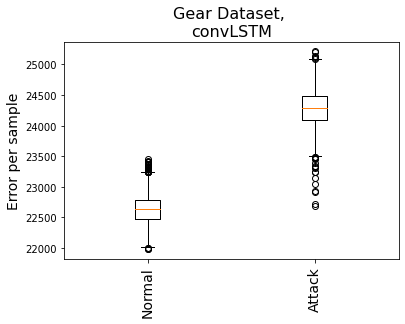

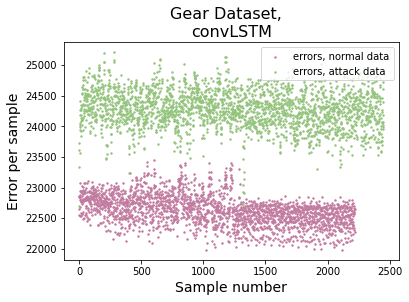

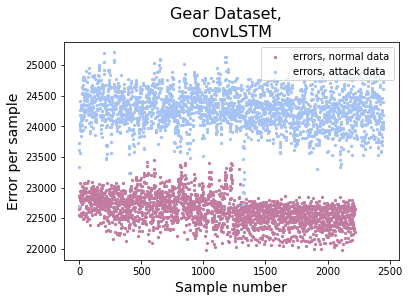

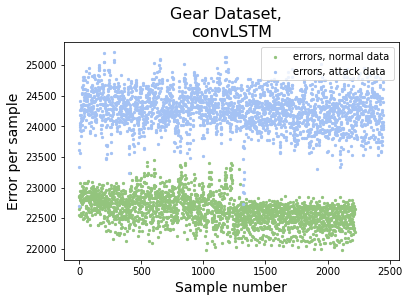

In [115]:
from matplotlib import pyplot as plt  
f = open('normal_errors.pckl', 'rb')
normal_errors = pickle.load(f)
f.close()

f = open('attack_errors.pckl', 'rb')
true_attack_errors = pickle.load(f)
f.close()

plt.figure()
plt.boxplot([normal_errors,true_attack_errors]) 
plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error per sample', fontsize=14)
plt.title('Gear Dataset, \nconvLSTM', fontsize=16)

#maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)
minAttack = np.min(true_attack_errors) - 0.01*np.max(normal_errors)
#maxNormal1 = optimal_threshold
#maxNormal2 = thresholds[best_threshold_location]

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='#c27ba0ff',s=2, alpha=1 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='#93c47dff',s=2, alpha=1)
plt.legend(['errors, normal data', 'errors, attack data'])
#plt.axis([-1000,27000,-10,250])
plt.title('Gear Dataset,  \nconvLSTM', fontsize=16)
plt.ylabel('Error per sample', fontsize=14)
plt.xlabel('Sample number', fontsize=14)


plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='#c27ba0ff',s=5, alpha=1 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='#a4c2f4ff',s=5, alpha=1)
plt.legend(['errors, normal data', 'errors, attack data'])
#plt.axis([-1000,27000,-10,250])
plt.title('Gear Dataset,  \nconvLSTM', fontsize=16)
plt.ylabel('Error per sample', fontsize=14)
plt.xlabel('Sample number', fontsize=14)
#plt.axhline(y=maxNormal1, color='k', linestyle='-')
#plt.axhline(y=maxNormal2, color='k', linestyle='--')

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='#93c47dff',s=5, alpha=1 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='#a4c2f4ff',s=5, alpha=1)
plt.legend(['errors, normal data', 'errors, attack data'])
#plt.axis([-1000,27000,-10,250])
plt.title('Gear Dataset,  \nconvLSTM', fontsize=16)
plt.ylabel('Error per sample', fontsize=14)
plt.xlabel('Sample number', fontsize=14)

In [10]:
true_attack_errors



array([773.9910527 , 718.86678297, 733.73756564, ..., 926.95521723,
       915.74319332, 899.25863878])

In [ ]:
#maxNormal = np.max(normal_errors) - 0.1*np.max(normal_errors)


false_normal = true_attack_errors[true_attack_errors<maxNormal1]
n_false_normal = len(false_normal)
false_attack = normal_errors[normal_errors>maxNormal1]
n_false_attack = len(false_attack)

all = len(true_attack_errors) + len(normal_errors)
false = n_false_normal+n_false_attack
print(f'false negative {n_false_normal}, false positive {n_false_attack}')
print(1-false/all)


false_normal = true_attack_errors[true_attack_errors<maxNormal2]
n_false_normal = len(false_normal)
false_attack = normal_errors[normal_errors>maxNormal2]
n_false_attack = len(false_attack)

print(f'false negative {n_false_normal}, false positive {n_false_attack}')
print(1-(n_false_normal+n_false_attack)/(len(true_attack_errors) + len(normal_errors)))



In [ ]:
from sklearn.metrics import RocCurveDisplay

true_positive = np.ones((len(true_attack_errors),))
true_negative = np.zeros((len(normal_errors),))
true_labels = np.concatenate([true_positive, true_negative])

n_errors = np.array([normal_errors])
n_errors = np.squeeze(n_errors)

a_errors = np.array([true_attack_errors])
a_errors = np.squeeze(a_errors)

scores = np.concatenate([a_errors,n_errors])

fpr, tpr, thresholds = metrics.roc_curve(true_labels, scores, pos_label=1)
#roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
# display.plot()  
# plt.show() 
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

In [ ]:
least_distance = 1
best_threshold_location = -1
for i in range(len(thresholds)):
    current_threshold = thresholds[i]
   
    x = fpr[i]
    y = tpr[i]
   
    distance = np.sqrt( (x - 0)**2 + (y - 1)**2 )
    if(distance < least_distance):
        least_distance = distance
        best_threshold_location = i
   
print(f'{best_threshold_location}, {least_distance}')

In [ ]:
    
    input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

   # x = Conv3D(filters = 5, kernel_size = (40, 40, 40), strides=(1, 1, 1), activation='relu', padding='same')(input) 
    # x = MaxPool3D((2,2,2),padding='same')(x)
    if x_train.shape[1] > 20:
        x = Conv3D(filters = 5, kernel_size = (21, 21, 21), activation='relu', strides=(1, 1, 1), padding='same')(input) 
        x = MaxPool3D((2,2,2),padding='same')(x)
    else: 
        x = Conv3D(filters = 3, kernel_size = (15, 15, 15),  activation='relu', strides=(1, 1, 1), padding='same')(input) 
        x = MaxPool3D((2,2,2),padding='same')(x)

    x = Conv3D(filters = 3, kernel_size = (11, 11, 11), strides=(1, 1, 1), activation='relu', padding='same')(x) 
    x = MaxPool3D((2,2,2),padding='same')(x)

    x = Conv3D(filters = 2, kernel_size = (9, 9, 3), strides=(1, 1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool3D((1,2,2),padding='same')(x)

    #x = Conv3D(filters = 5, kernel_size = (3, 3, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
    #x = MaxPool3D((2,2,2),padding='same')(x)

    x = Conv3DTranspose(2,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

    x = Conv3DTranspose(1,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

    #x = Conv3DTranspose(1,kernel_size=(11,11,11), strides=(1, 1, 1))(x)

    k1 = x_train.shape[1] - x.shape[1] + 1
    k2 = x_train.shape[2] - x.shape[2] + 1
    k3 = x_train.shape[3] - x.shape[3] + 1 

    x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

    CNN = Model(inputs=input, outputs=x,name="CNN")
    CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
    CNN.summary()

    model = CNN

In [10]:
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))


x = Conv3D(filters = 2, kernel_size = (9, 9, 3), strides=(2, 2, 2), padding='same')(input)

x = MaxPool3D((1,2,2),padding='same')(x)

x = Conv3D(filters = 2, kernel_size = (3, 11, 3), strides=(2, 2, 2), padding='same')(input)
x = Activation('relu')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

x = Conv3D(filters = 5, kernel_size = (3, 3, 1), strides=(1, 1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3DTranspose(2,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

# x = Conv3DTranspose(1,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

# #x = Conv3DTranspose(1,kernel_size=(11,11,11), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1
k2 = x_train.shape[2] - x.shape[2] + 1
k3 = x_train.shape[3] - x.shape[3] + 1 

x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 64, 17, 1)]    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 32, 9, 2)       200       
_________________________________________________________________
activation (Activation)      (None, 3, 32, 9, 2)       0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 16, 5, 2)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 16, 5, 5)       95        
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 16, 5, 5)       20        
_________________________________________________________________
activation_1 (Activation)    (None, 3, 16, 5, 5)       0       

In [22]:
n_filters = 5
denseUnits = n_filters* 32
x_train.shape[3]
model = Sequential()
n_features = 64
model.add(
    TimeDistributed(
        Conv2D(5, (11,11), activation='relu',padding='same',strides = (2,2)), 
        input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]
, 1) # 5 images...
    )
)

model.add(
    TimeDistributed(
        MaxPool2D((2, 2),padding='same')
    )
)

model.add(
    TimeDistributed(
        Conv2D(n_filters, (11,9), activation='relu',padding='same',strides = (2,2))
    )
)

model.add(
    TimeDistributed(
        MaxPool2D((2, 2),padding='same')
    )
)

model.add(
    Reshape((n_timesteps,-1)))

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
   LSTM(10, activation='relu', return_sequences=True)
)

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
    TimeDistributed(
        BatchNormalization()
    )
)
model.add(
    TimeDistributed(
        Dense(denseUnits)
    )
)

model.add(
    Reshape((n_timesteps,32,1,n_filters)))

model.add(
    TimeDistributed(
        UpSampling2D((2,17))
    )
)

model.add(
    TimeDistributed(
        Conv2D(1, (1,1), activation='relu',padding='same')
    )
)

model.compile('adam', loss='KLDivergence')

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_79 (TimeDis (None, 40, 32, 9, 5)      610       
_________________________________________________________________
time_distributed_80 (TimeDis (None, 40, 16, 5, 5)      0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 40, 8, 3, 5)       2480      
_________________________________________________________________
time_distributed_82 (TimeDis (None, 40, 4, 2, 5)       0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 40, 40)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 40, 128)           86528     
_________________________________________________________________
lstm_43 (LSTM)               (None, 40, 10)          

In [25]:
x_train.shape

(2219, 40, 64, 17, 1)

In [75]:
# CONVLSTM
#samples, time, rows, cols, channels

input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3],1))


x = ConvLSTM2D(filters = 2, kernel_size = (11, 9),strides=(2, 2),return_sequences=True)(input)
x = ConvLSTM2D(filters = 2, kernel_size = (9, 3),strides=(2, 1),return_sequences=True)(x)


x = Conv3D(filters = 2, kernel_size = (3, 11, 3), strides=(2, 2, 1), padding='same')(x)
x = Activation('relu')(x)
x = MaxPool3D((1,2,1),padding='same')(x)

x = Conv3D(filters = 5, kernel_size = (3, 3, 1), strides=(1, 1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool3D((1,2,1),padding='same')(x)

x = Conv3DTranspose(2,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(1,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(1,kernel_size=(11,11,11), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1
k2 = x_train.shape[2] - x.shape[2] + 1
k3 = x_train.shape[3] - x.shape[3] + 1 

x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1
x = ConvLSTM2D(filters = 2, kernel_size = (9, 3),strides=(2, 1),return_sequences=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (9, 3),strides=(2, 1),return_sequences=True)(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 40, 64, 17, 1)]   0         
_________________________________________________________________
conv_lst_m2d_48 (ConvLSTM2D) (None, 40, 27, 5, 2)      2384      
_________________________________________________________________
conv_lst_m2d_49 (ConvLSTM2D) (None, 40, 10, 3, 2)      872       
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 20, 5, 3, 2)       398       
_________________________________________________________________
activation_37 (Activation)   (None, 20, 5, 3, 2)       0         
_________________________________________________________________
max_pooling3d_38 (MaxPooling (None, 20, 3, 3, 2)       0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 20, 3, 3, 5)       95      

In [88]:
n_filters = 5
denseUnits = n_filters* 32
x_train.shape[3]
n_features = 64

input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))

x = TimeDistributed(Conv2D(5, (11,11), activation='relu',padding='same',strides = (2,2)), 
        input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))(input)

x = TimeDistributed(MaxPool2D((2, 2),padding='same'))(x)

x = TimeDistributed(Conv2D(n_filters, (11,9), activation='relu',padding='same',strides = (2,2)))(x)

x = TimeDistributed(MaxPool2D((2,2), padding = 'same'))(x)

x = Reshape((n_timesteps,-1))(x)

x = LSTM(128, activation='relu', return_sequences=True)(x)

x = LSTM(10, activation='relu', return_sequences=True)(x)

x =  LSTM(128, activation='relu', return_sequences=True)(x)

x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed(Dense(denseUnits))(x)

x = Reshape((n_timesteps,32,1,n_filters))(x)

x = TimeDistributed(UpSampling2D((2,17)))(x)

x = TimeDistributed(Conv2D(1, (1,1), activation='relu',padding='same'))(x)

model = Model(inputs=input, outputs=x,name="CNN")
model.compile('adam', loss='KLDivergence')

model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 40, 64, 17, 1)]   0         
_________________________________________________________________
time_distributed_139 (TimeDi (None, 40, 32, 9, 5)      610       
_________________________________________________________________
time_distributed_140 (TimeDi (None, 40, 16, 5, 5)      0         
_________________________________________________________________
time_distributed_141 (TimeDi (None, 40, 8, 3, 5)       2480      
_________________________________________________________________
time_distributed_142 (TimeDi (None, 40, 4, 2, 5)       0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 40, 40)            0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 40, 128)           86528   

In [17]:
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3],1))


x = ConvLSTM2D(filters = 2, kernel_size = (11, 9),strides=(1, 1),return_sequences=True)(input)
x, state_h, state_c = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True)(x, initial_state = [state_h,state_c])

x = ConvLSTM2D(filters = 2, kernel_size = (9, 3),strides=(2, 1),return_sequences=True)(x)
x, state_h, state_c = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True)(x, initial_state = [state_h,state_c])

x = ConvLSTM2D(filters = 2, kernel_size = (5, 3),strides=(2, 1),return_sequences=True)(x)
x, state_h, state_c = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True)(x, initial_state = [state_h,state_c])

x = ConvLSTM2D(filters = 2, kernel_size = (3, 1),strides=(1, 1),return_sequences=True)(x)
x, state_h, state_c = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True)(x, initial_state = [state_h,state_c])

x = ConvLSTM2D(filters = 2, kernel_size = (3, 1),strides=(1, 1),return_sequences=True)(x)
x, state_h, state_c = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True)(x)
x = ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True)(x, initial_state = [state_h,state_c])
print(x.shape)
k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2]-50 - x.shape[2] + 1
k3 = x_train.shape[3]-12 - x.shape[3] + 1 

x = Conv3DTranspose(2,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2]-40 - x.shape[2] + 1
k3 = x_train.shape[3]-12 - x.shape[3] + 1 

x = Conv3DTranspose(2,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2]-30 - x.shape[2] + 1
k3 = x_train.shape[3]-10 - x.shape[3] + 1 

x = Conv3DTranspose(2,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2]-20 - x.shape[2] + 1
k3 = x_train.shape[3]-7 - x.shape[3] + 1 

x = Conv3DTranspose(2,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2]-10 - x.shape[2] + 1
k3 = x_train.shape[3]-5 - x.shape[3] + 1 

x = Conv3DTranspose(2,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2] - x.shape[2] + 1
k3 = x_train.shape[3] - x.shape[3] + 1 

x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN

(None, 40, 6, 5, 2)
Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 40, 64, 17,  0                                            
__________________________________________________________________________________________________
conv_lst_m2d_162 (ConvLSTM2D)   (None, 40, 54, 9, 2) 2384        input_14[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_163 (ConvLSTM2D)   [(None, 40, 54, 9, 2 40          conv_lst_m2d_162[0][0]           
__________________________________________________________________________________________________
conv_lst_m2d_164 (ConvLSTM2D)   (None, 40, 54, 9, 2) 40          conv_lst_m2d_163[0][0]           
                                                                 conv_lst_m2

In [40]:
from keras.layers import Bidirectional
# add activations and other params
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3],1))
x = TimeDistributed(Dense(300, activation='sigmoid'))(input)
x = TimeDistributed(Dropout(0.2))(x)
x = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (11, 9),strides=(1, 1),return_sequences=True,return_state=False),merge_mode='sum')(x)

x, state_h1, state_c1, state_h2, state_c2 = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True), merge_mode='sum')(x)

x = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True),  merge_mode='sum')(x, initial_state = [state_h1,state_c1, state_h2, state_c2])

x = TimeDistributed(BatchNormalization())(x)

x = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (9, 3),strides=(1, 1),return_sequences=True,return_state=False),merge_mode='sum')(x)

x, state_h1, state_c1, state_h2, state_c2 = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True,return_state=True),merge_mode='sum')(x)

x = Bidirectional(ConvLSTM2D(filters = 2, kernel_size = (1, 1),strides=(1, 1),return_sequences=True),merge_mode='sum' )(x, initial_state = [state_h1, state_c1, state_h2, state_c2])



k1 = x_train.shape[1] - x.shape[1] + 1 
k2 = x_train.shape[2] - x.shape[2] + 1
k3 = x_train.shape[3] - x.shape[3] + 1 

x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1
x = TimeDistributed(Dense(300, activation='sigmoid'))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 40, 64, 17,  0                                            
__________________________________________________________________________________________________
time_distributed_55 (TimeDistri (None, 40, 64, 17, 3 600         input_28[0][0]                   
__________________________________________________________________________________________________
time_distributed_56 (TimeDistri (None, 40, 64, 17, 3 0           time_distributed_55[0][0]        
__________________________________________________________________________________________________
bidirectional_182 (Bidirectiona (None, 40, 54, 9, 2) 478384      time_distributed_56[0][0]        
________________________________________________________________________________________________

In [31]:
print(x_test.shape)
print(x_test[0,0,:])
print(yHat_normal.shape)
print(yHat_normal[0,0,:])

(106, 40, 64)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0]
(106, 40, 64)
[6.9915934e-10 3.4132466e-17 7.6876621e-09 8.5842427e-09 7.8143526e-14
 5.3387286e-08 6.3264861e-07 3.3821234e-06 2.7778745e-04 6.8518203e-12
 7.0647953e-11 9.7349551e-14 1.1687804e-10 9.4478294e-22 1.3335189e-18
 6.9146471e-14 1.3483632e-18 8.5474148e-17 9.0771816e-17 1.4077760e-10
 1.4516414e-17 8.2241219e-10 5.9232198e-13 4.7212285e-18 2.5881064e-10
 2.2673599e-09 8.0862633e-10 4.0685885e-10 8.0104829e-12 1.9576177e-11
 3.2227599e-12 4.0698361e-11 3.0015588e-09 5.2531512e-05 1.8201592e-05
 9.9987060e-01 2.6958121e-05 3.2534950e-05 7.1612427e-05 2.2052868e-07
 8.0675981e-16 1.2962127e-12 9.9999106e-01 1.4502942e-05 9.9948967e-01
 1.1029840e-03 1.6200183e-05 9.9999917e-01 8.1447037e-12 2.7710090e-10
 9.9988914e-01 3.6983214e-14 9.9943757e-01 7.5675672e-07 9.9737513e-01
 9.2556951e-07 4.7385947e-07 1.6813278e-03 9.9999607e-01 1.1

In [2]:
model = keras.models.load_model('2d_cnn_lstm_final')
model.summary()


<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000001C6B3006880>>

In [59]:
input = Input(shape=(64,17,40,1))

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (21, 11), activation='relu', padding='same'))(input) 
x = TimeDistributed(MaxPool2D((2,2),padding='valid'))(x)

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (11, 3), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(MaxPool2D((2,2)))(x)


x = Reshape((n_timesteps,-1))(x)
x = LSTM(64,return_sequences = True)(x)
x,h,c = LSTM(64,return_sequences = True,return_state=True)(x)
x = LSTM(64,return_sequences = True)(x,initial_state=[h,c])
x = LSTM(128, return_sequences = True)(x)

x = TimeDistributed(Reshape((64,2,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 5), activation='relu', padding='valid',strides=(1,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 12), activation='relu', padding='valid',strides=(1,1)))(x)
x = keras.layers.Permute((2,3,1,4))(x)
x = TimeDistributed(Dense(1,activation='sigmoid'))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN

(None, 40, 128)
Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 64, 17, 40,  0                                            
__________________________________________________________________________________________________
time_distributed_247 (TimeDistr (None, 64, 17, 40, 5 1160        input_35[0][0]                   
__________________________________________________________________________________________________
time_distributed_248 (TimeDistr (None, 64, 8, 20, 5) 0           time_distributed_247[0][0]       
__________________________________________________________________________________________________
time_distributed_249 (TimeDistr (None, 64, 8, 20, 5) 830         time_distributed_248[0][0]       
________________________________________________________________________________

In [34]:
print(x.shape[0])

None


In [20]:
x_train.shape

(23, 64, 17, 40)

In [ ]:
modelname = 'bidirectional_withDense'
#modelname = '3dCNN_05-18_trained_on_50000_r'
CNN =  keras.models.load_model(modelname)

In [104]:
print(x_train.shape[1])
print(x_train.shape[2])
print(x_train.shape[3])


40
64
17


In [45]:

    n_filters = 5
    denseUnits = n_filters* 32
    x_train.shape[3]
    model = Sequential()
    n_features = 64
    model.add(
        TimeDistributed(
            Conv2D(5, (11,11), activation='relu',padding='same',strides = (2,2)), 
            input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]
    , 1) # 5 images...
        )
    )

    model.add(
        TimeDistributed(
            MaxPool2D((2, 2),padding='same')
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(n_filters, (11,9), activation='relu',padding='same',strides = (2,2))
        )
    )

    model.add(
        TimeDistributed(
            MaxPool2D((2, 2),padding='same')
        )
    )

    model.add(
        Reshape((n_timesteps,-1)))

    model.add(
    LSTM(128, activation='relu', return_sequences=True)
    )

    model.add(
    LSTM(10, activation='relu', return_sequences=True)
    )

    model.add(
    LSTM(128, activation='relu', return_sequences=True)
    )

    model.add(
        TimeDistributed(
            BatchNormalization()
        )
    )
    model.add(
        TimeDistributed(
            Dense(denseUnits)
        )
    )

    model.add(
        Reshape((n_timesteps,32,1,n_filters)))

    model.add(
        TimeDistributed(
            UpSampling2D((2,17))
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(1, (1,1), activation='relu',padding='same')
        )
    )

    model.compile('adam', loss='BinaryCrossentropy')

    model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_220 (TimeDi (None, 64, 9, 20, 5)      610       
_________________________________________________________________
time_distributed_221 (TimeDi (None, 64, 5, 10, 5)      0         
_________________________________________________________________
time_distributed_222 (TimeDi (None, 64, 3, 5, 5)       2480      
_________________________________________________________________
time_distributed_223 (TimeDi (None, 64, 2, 3, 5)       0         
_________________________________________________________________
reshape_50 (Reshape)         (None, 40, 48)            0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 40, 128)           90624     
_________________________________________________________________
lstm_78 (LSTM)               (None, 40, 10)          

In [7]:
x_train.shape

(23, 40, 64, 17, 1)

In [5]:
from keras.layers import Permute

In [11]:
input = Input(shape=(40, 64, 17, 1))

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (21, 11), activation='relu', padding='same'))(input) 
x = TimeDistributed(MaxPool2D((2,2),padding='valid'))(x)

x = TimeDistributed(Conv2D(filters = 5, kernel_size = (11, 3), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(MaxPool2D((2,2)))(x)

x = Reshape((40,-1))(x)
x = LSTM(64,return_sequences = True)(x)
x,h,c = LSTM(64,return_sequences = True,return_state=True)(x)
x = LSTM(64,return_sequences = True)(x,initial_state=[h,c])
x = LSTM(128, return_sequences = True)(x)

x = TimeDistributed(Reshape((64,2,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 5), activation='relu', padding='valid',strides=(1,1)))(x)
x = TimeDistributed(Conv2DTranspose(filters = 5, kernel_size = (1, 12), activation='relu', padding='valid',strides=(1,1)))(x)
#x = Permute((2,3,1,4))(x)
x = TimeDistributed(Dense(1,activation='sigmoid'))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='BinaryCrossentropy')
CNN.summary()

model = CNN 

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 40, 64, 17,  0                                            
__________________________________________________________________________________________________
time_distributed_29 (TimeDistri (None, 40, 64, 17, 5 1160        input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_30 (TimeDistri (None, 40, 32, 8, 5) 0           time_distributed_29[0][0]        
__________________________________________________________________________________________________
time_distributed_31 (TimeDistri (None, 40, 32, 8, 5) 830         time_distributed_30[0][0]        
________________________________________________________________________________________________